In [1]:
import pickle
import glob
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.ndimage.measurements import label
from features import convert_cspace, bin_spatial, color_hist, get_hog_features
%matplotlib inline

In [2]:
# Load the latest saved model
latest_model = max(glob.glob('./saved_models/*.p'))
with open(latest_model, 'rb') as f:
    dist_pickle = pickle.load(f)
    print('Successfully loaded {}'.format(latest_model))

svc = dist_pickle['svc']
X_scaler = dist_pickle['X_scaler']
params = dist_pickle['params']

Successfully loaded ./saved_models/2017-03-05T02:17:55Z|test_acc=0.9935|train_samples=14208|test_samples=3552.p


In [5]:
def draw_boxes(img, bboxes, color=(255, 0, 0), thick=6):
    draw_img = np.copy(img)
    for box in bboxes:
        if not box:
            continue            
        cv2.rectangle(draw_img, box[0], box[1], color, thick)
    return draw_img

# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, cspace, spatial_size, hist_bins, hist_range, 
              orient, pix_per_cell, cell_per_block, hog_channel):
    
    bboxes = []
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_cspace(img_tosearch, cspace)
    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the original sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.ravel((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get spatial and color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins, bins_range=hist_range)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.concatenate((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                bboxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return bboxes

In [ ]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (255,0,0), 6)
    # Return the image
    return img

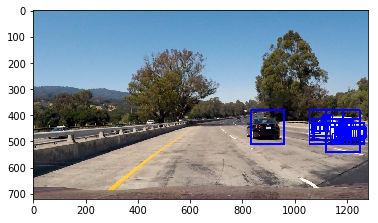

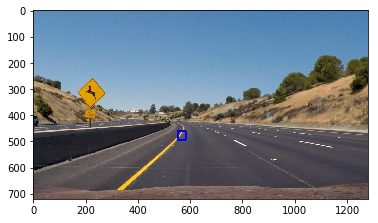

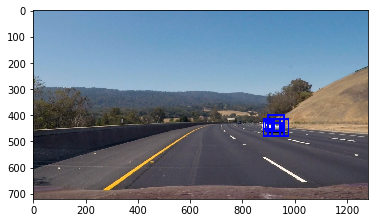

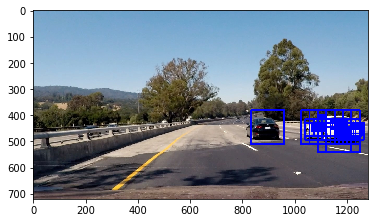

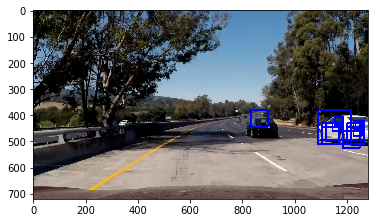

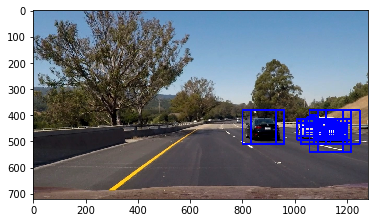

In [8]:
test_images = glob.glob('./test_images/*.jpg')

for fname in glob.glob('./test_images/*.jpg'):
    img = cv2.imread(fname)
    plt.figure()
    
    bboxes = []
    
    # small scale
    bboxes += find_cars(img, 350, 550, 0.5, svc, X_scaler, **params)
    
    # med scale
    bboxes += find_cars(img, 350, 656, 1., svc, X_scaler, **params)

    # large scale
    bboxes += find_cars(img, 350, 656, 2, svc, X_scaler, **params)
 
    annotated = cv2.cvtColor(draw_boxes(img, bboxes), cv2.COLOR_BGR2RGB)
    plt.figure()
    plt.imshow(annotated)